In [1]:
from __future__ import print_function
import argparse
import pickle

import numpy as np
import torch
from captum.attr import IntegratedGradients

import cbig.osama2024.misc as misc

f:\Professional\Thesis\RNN-AD\RNN_py3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### predict functions

In [2]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--checkpoint', required=True)
    parser.add_argument('--data', required=True)
    parser.add_argument('--out', '-o', required=True)

    return parser.parse_args()


def predict_subject(model, cat_seq, value_seq, time_seq):
    """
    Predict Alzheimer’s disease progression for a subject
    Args:
        model: trained pytorch model
        cat_seq: sequence of diagnosis [nb_input_timpoints, nb_classes]
        value_seq: sequence of other features [nb_input_timpoints, nb_features]
        time_seq: months from baseline [nb_output_timpoints, nb_features]
    nb_input_timpoints <= nb_output_timpoints
    Returns:
        out_cat: predicted diagnosis
        out_val: predicted features
    """
    in_val = np.full((len(time_seq), ) + value_seq.shape[1:], np.nan)
    in_val[:len(value_seq)] = value_seq

    in_cat = np.full((len(time_seq), ) + cat_seq.shape[1:], np.nan)
    in_cat[:len(cat_seq)] = cat_seq

    with torch.no_grad():
        out_cat, out_val = model(in_cat, in_val)
    out_cat = out_cat.cpu().numpy()
    out_val = out_val.cpu().numpy()

    assert out_cat.shape[1] == out_val.shape[1] == 1

    return out_cat, out_val


def predict(model, dataset, pred_start, duration, baseline):
    """
    Predict Alzheimer’s disease progression using a trained model
    Args:
        model: trained pytorch model
        dataset: test data
        pred_start (dictionary): the date at which prediction begins
        duration (dictionary): how many months into the future to predict
        baseline (dictionary): the baseline date
    Returns:
        dictionary which contains the following key/value pairs:
            subjects: list of subject IDs
            DX: list of diagnosis prediction for each subject
            ADAS13: list of ADAS13 prediction for each subject
            Ventricles: list of ventricular volume prediction for each subject
    """
    model.eval()
    ret = {'subjects': dataset.subjects}
    ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
    ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
    ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
    ret['dates'] = misc.make_date_col(
        [pred_start[s] for s in dataset.subjects], duration)

    col = ['ADAS13', 'Ventricles', 'ICV']
    indices = misc.get_index(list(dataset.value_fields()), col)
    mean = model.mean[col].values.reshape(1, -1)
    stds = model.stds[col].values.reshape(1, -1)

    for i in range(len(dataset)):  # Iterate over subjects using indices
        data = dataset[i]  # Access data using index
        # print the columns
        #print(data.keys())
        rid = data['rid']
        all_tp = data['tp'].squeeze(axis=1)
        start = misc.month_between(pred_start[rid], baseline[rid])
        assert np.all(all_tp == np.arange(len(all_tp)))
        mask = all_tp < start
        itime = np.arange(start + duration)
        icat = np.asarray(
            [misc.to_categorical(c, 3) for c in data['cat'][mask]])
        ival = data['val'][:, None, :][mask]

        ocat, oval = predict_subject(model, icat, ival, itime)
        oval = oval[-duration:, 0, indices] * stds + mean

        ret['DX'].append(ocat[-duration:, 0, :])
        ret['ADAS13'].append(misc.add_ci_col(oval[:, 0], 1, 0, 85))
        ret['Ventricles'].append(
            misc.add_ci_col(oval[:, 1] / oval[:, 2], 5e-4, 0, 1))

    return ret

### IG

In [3]:
checkpoint_path = 'output/model.pt'
data_path = 'output/val.pkl'

device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load(checkpoint_path)
model.to(device)

with open(data_path, 'rb') as fhandler:
    data = pickle.load(fhandler)

In [4]:
integrated_gradients = IntegratedGradients(model)

In [5]:
# print the keys of data
print(data.keys())

dict_keys(['baseline', 'pred_start', 'duration', 'mean', 'stds', 'VentICVstd', 'train', 'test'])


In [34]:
test_data = data['test']
pred_start = data['pred_start']
duration = data['duration']
baseline = data['baseline']

model.eval()
ret = {'subjects': test_data.subjects}
ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
ret['dates'] = misc.make_date_col(
    [pred_start[s] for s in test_data.subjects], duration)

col = ['ADAS13', 'Ventricles', 'ICV']
indices = misc.get_index(list(test_data.value_fields()), col)
mean = model.mean[col].values.reshape(1, -1)
stds = model.stds[col].values.reshape(1, -1)

attributions = {}
    
for i in range(len(test_data)):
    data_entry = test_data[i]
    rid = data_entry['rid']
    all_tp = data_entry['tp'].squeeze(axis=1)
    start = misc.month_between(pred_start[rid], baseline[rid])
    assert np.all(all_tp == np.arange(len(all_tp)))
    mask = all_tp < start
    itime = np.arange(start + duration)
    icat = np.asarray(
        [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
    ival = data_entry['val'][:, None, :][mask]
    
    in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
    in_val[:len(ival)] = ival
    
    in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
    in_cat[:len(icat)] = icat
    
    input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
    input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
    # input_val = in_val
    # input_cat = in_cat
    
    target = (0,0,0,0)
    # convert to tensor
    target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
    
    attr_cat = integrated_gradients.attribute(
        inputs=(input_cat, input_val), 
        baselines=None,  # You can provide baselines if needed
        target=(0,1)  # You can specify the target output index if needed
    )
    
    # Save attributions
    attributions[rid] = {
        'cat': attr_cat
    }
    
    # ocat, oval = predict_subject(model, icat, ival, itime)


In [56]:
print(len(attributions[7]))

1


In [48]:
print(len(attributions.keys()))

159


In [67]:
print(len(attributions[15]['cat'][0]))
print(attributions[15]['cat'][1][1])

85
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       dtype=torch.float64)


In [35]:
# print attribution for rid 7
print(attributions[35]['cat'])

#print dimension of the attribution
print(len(attributions[7]['cat']))

(tensor([[[0.0437, 0.0000, 0.0000]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],

        [[   nan,    nan,    nan]],



ValueError: x and y can be no greater than 2D, but have shapes (85,) and (85, 1, 3)

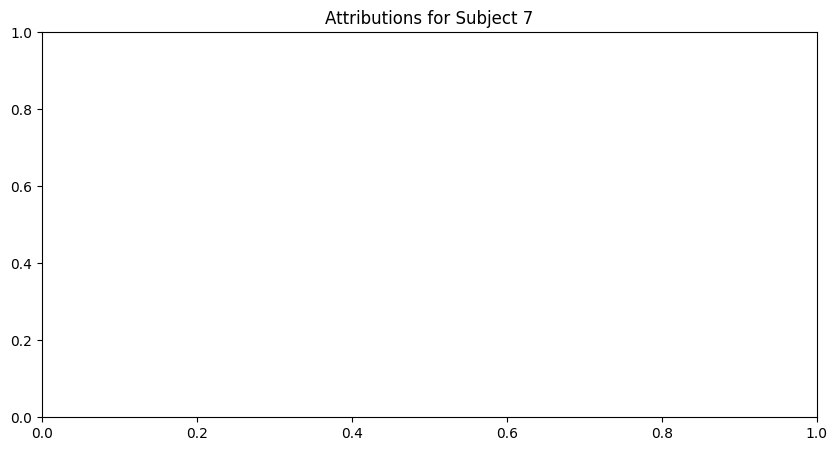

In [44]:
import matplotlib.pyplot as plt

# Iterate over the attributions dictionary
for rid, attr_dict in attributions.items():
    # Extract the attributions for categorical input
    attr_cat_tuple = attr_dict['cat']
    
    # Assuming the tuple contains (attributions_tensor, some_other_value)
    attr_cat_tensor = attr_cat_tuple[0]  # Extract the tensor from the tuple
    
    # Plot the attributions for categorical input
    plt.figure(figsize=(10, 5))
    plt.title(f'Attributions for Subject {rid}')
    plt.plot(attr_cat_tensor.cpu().numpy(), label='Attribution')  # Plot attributions over time steps
    plt.xlabel('Time Step')
    plt.ylabel('Attribution')
    plt.legend()
    plt.show()
